# Gradcam for Resnet 18 on CIFAR 10 dataset 

### Downloading the dataset

In [1]:

import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train/=255
x_test/=255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


In [3]:
(x_train.shape, x_test.shape)

((50000, 32, 32, 3), (10000, 32, 32, 3))

### Building and loading the pretrained resnet-18 model

In [2]:
!pip install image-classifiers

from classification_models import Classifiers
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.advanced_activations import Softmax

     |████████████████████████████████| 81kB 3.8MB/s 


In [0]:
classifier, preprocess_input = Classifiers.get('resnet18')
base_model = classifier((32, 32, 3), weights='imagenet', include_top=False)

Attaching the custom head

In [0]:
x=base_model.output    
x=Flatten()(x)
x = Dense(256, activation='softmax')(x)
predictions=Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

Loading the weights from the google drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
!ls drive/"My Drive"/"EIP 3"/"phase 2"/"A1"
!cp drive/"My Drive"/"EIP 3"/"phase 2"/"A1"/"resnet_18.h5" .

resnet_18.h5


In [0]:
model.load_weights("resnet_18.h5")

### Get mis classified images

In [0]:
predict = model.predict(x_test)

In [0]:
import numpy as np
predicted_labels = [np.argmax(x, axis=-1) for x in predict]
labels = [np.argmax(x, axis=-1) for x in y_test]
mis_classified_indices = [i for i, x in enumerate(predicted_labels) if predicted_labels[i]!=labels[i]]

In [27]:
mis_classified_indices[:5]

[9, 25, 33, 35, 47]

### GradCam

In [0]:
import random
%matplotlib inline
from keras import backend as k
from PIL import Image
from numpy import zeros, newaxis
import cv2
from google.colab.patches import cv2_imshow
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [0]:
def get_random_misclassified_indices(num):
  return random.sample([i for i in range(len(mis_classified_indices))], num)

In [39]:
get_random_misclassified_indices(10)

[876, 707, 712, 525, 861, 1176, 544, 735, 890, 539]

In [0]:
last_layer = -44

In [0]:
def get_heat_map_images(index):
  class_idx = np.argmax(predict[index], axis=-1)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.layers[last_layer]
  class_output = model.output[:, class_idx]
  img = x_test[index]
  img = img.copy()
  x = [img]
  grads = k.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = k.mean(grads, axis=(0, 1, 2))
  iterate = k.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(128):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  img = np.uint8(255 * img)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  return img, superimposed_img

In [63]:
class_idx = np.argmax(predict[876], axis=-1)
model.output[:, class_idx]

<tf.Tensor 'strided_slice_181:0' shape=(?,) dtype=float32>

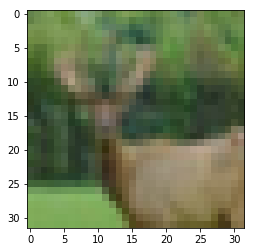

In [56]:
plt.imshow(get_heat_map_images(876)[0])

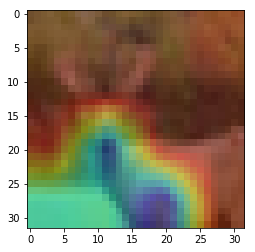

In [57]:
plt.imshow(get_heat_map_images(876)[1])

In [0]:
def plot_images(num_rows, num_cols):
  misclassified_indices = get_random_misclassified_indices(num_rows*num_cols)
  f, axarr = plt.subplots(num_rows, num_cols*2)
  for v, i in enumerate(misclassified_indices):
    img, superimposed_img = get_heat_map_images(i)
    axarr[int(v/num_cols),2*(v%num_cols)].imshow(img)
    axarr[int(v/num_cols),2*(v%num_cols)+1].imshow(superimposed_img)

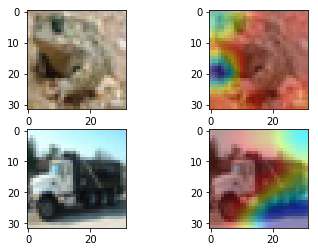

In [114]:
plot_images(2, 1)

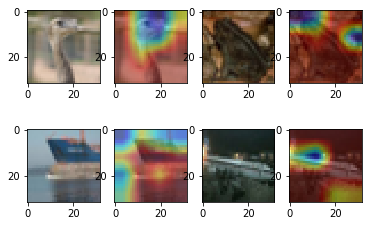

In [115]:
plot_images(2, 2)

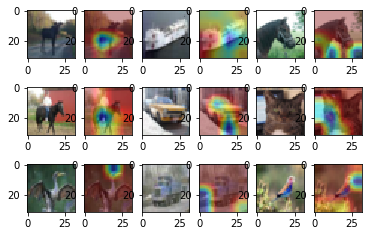

In [33]:
plot_images(3, 3)

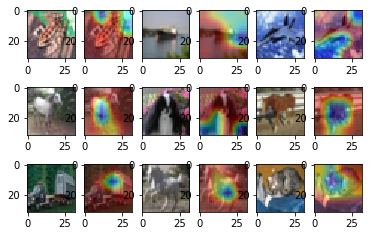

In [34]:
plot_images(3, 3)

### Download images to drive to put in github gallery folder

In [139]:
!pip install pillow
import matplotlib

In [0]:
def plot_both_images(index):
  file_name = str(index)+'.jpg'
  img, superimposed_img = get_heat_map_images(index);
  fig, axarr = plt.subplots(1, 2)
  axarr[0].imshow(img)
  axarr[1].imshow(superimposed_img)
  fig.savefig("gallery/"+file_name)
  print("saved the image " + file_name + " to local gallery")

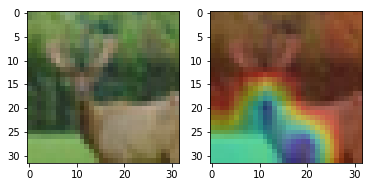

In [137]:
plot_both_images(876)

In [0]:
def get_final_images_and_save(num):
  misclassified_indices = get_random_misclassified_indices(num)
  for v, i in enumerate(misclassified_indices):
    plot_both_images(i)

In [0]:
get_final_images_and_save(50)

In [143]:
!ls gallery

1004.jpg  1084.jpg  138.jpg  273.jpg  452.jpg  562.jpg	698.jpg  916.jpg
1049.jpg  1090.jpg  164.jpg  292.jpg  474.jpg  585.jpg	703.jpg  970.jpg
1051.jpg  1126.jpg  184.jpg  404.jpg  483.jpg  604.jpg	705.jpg  973.jpg
1058.jpg  1139.jpg  191.jpg  406.jpg  493.jpg  626.jpg	825.jpg
1061.jpg  1173.jpg  238.jpg  414.jpg  507.jpg  627.jpg	828.jpg
1062.jpg  1174.jpg  256.jpg  423.jpg  525.jpg  657.jpg	876.jpg
106.jpg   1198.jpg  259.jpg  436.jpg  536.jpg  67.jpg	882.jpg


In [0]:
!cp ./gallery/* "./drive/My Drive/EIP 3/phase 2/A1/gallery"

In [145]:
!ls -lah gallery

total 1.5M
drwxr-xr-x 2 root root 4.0K Jul 12 12:47 .
drwxr-xr-x 1 root root 4.0K Jul 12 12:42 ..
-rw-r--r-- 1 root root  23K Jul 12 12:47 1004.jpg
-rw-r--r-- 1 root root  27K Jul 12 12:45 1049.jpg
-rw-r--r-- 1 root root 1.5K Jul 12 12:24 1051.jpg
-rw-r--r-- 1 root root  31K Jul 12 12:47 1058.jpg
-rw-r--r-- 1 root root  25K Jul 12 12:47 1061.jpg
-rw-r--r-- 1 root root  22K Jul 12 12:44 1062.jpg
-rw-r--r-- 1 root root  25K Jul 12 12:45 106.jpg
-rw-r--r-- 1 root root  22K Jul 12 12:44 1084.jpg
-rw-r--r-- 1 root root  22K Jul 12 12:46 1090.jpg
-rw-r--r-- 1 root root  21K Jul 12 12:46 1126.jpg
-rw-r--r-- 1 root root  26K Jul 12 12:46 1139.jpg
-rw-r--r-- 1 root root  26K Jul 12 12:45 1173.jpg
-rw-r--r-- 1 root root  25K Jul 12 12:46 1174.jpg
-rw-r--r-- 1 root root  28K Jul 12 12:44 1198.jpg
-rw-r--r-- 1 root root  26K Jul 12 12:44 138.jpg
-rw-r--r-- 1 root root  26K Jul 12 12:45 164.jpg
-rw-r--r-- 1 root root  26K Jul 12 12:45 184.jpg
-rw-r--r-- 1 root root  27K Jul 12 12:46 191.jpg
-rw-r--